# Reconhecimento de Entidades Nomeadas

> Murilo Simionato Arnemann - 18/0107453


Anotação de Textos e Processamento de Linguagem Natural

2022 - Universidade de Brasília



## Clonando o dataset

In [1]:
!git clone https://github.com/murilo-simio/text_classifier

fatal: destination path 'text_classifier' already exists and is not an empty directory.


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('/content/text_classifier/contratos_idato.csv')

In [4]:
df['id_ato'] = df['id_dodf'] + '-' + df['id_rel']

## Clonando o Repositório

In [5]:
!git clone -s https://github.com/mstauffer/tcdf_text_classification.git

fatal: destination path 'tcdf_text_classification' already exists and is not an empty directory.


In [6]:
from tcdf_text_classification.iob_transformer import iob_transformer

In [7]:
iob = iob_transformer('id_ato', 'texto', 'tipo_ent', keep_punctuation=True)

In [8]:
import nltk

In [9]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Pegando as labels do dataset

In [10]:
atos, labels = iob.transform(df)

In [11]:
%matplotlib inline

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

np.random.seed(0)
plt.style.use("ggplot")



In [13]:
words = set()
for ato in atos:
  for termo in ato:
    words.add(termo)
words = list(words)
words.append("ENDPAD")
words.append("UNK")

In [14]:
tags = set()
for label in labels:
  for tag in label:
    tags.add(tag)
tags = list(tags)

## Criando os dois dicionários

In [15]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

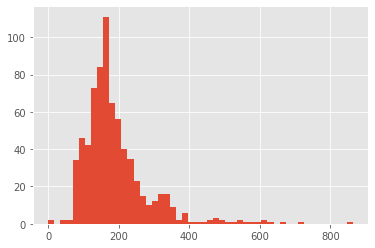

In [16]:
plt.hist([len(ato) for ato in atos], bins=50)
plt.show()

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
max_len = 250
X = [[word2idx[w] for w in ato] for ato in atos]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx['ENDPAD'])

y = [[tag2idx[w] for w in label] for label in labels]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

## Separando os dados em teste, validação e treinamento

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=1)

## Montando o modelo

In [20]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [21]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=len(words)+1, output_dim=70, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(len(tags), activation="relu"))(model)
out = TimeDistributed(Dense(len(tags), activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding (Embedding)       (None, 250, 70)           861210    
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 70)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 250, 200)         136800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 250, 72)          14472     
 ibuted)                                                         
                                                             

In [22]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [23]:
!pip install livelossplot

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

### Checkpoints para parar o treinamento caso não melhore

In [25]:
chkpt = ModelCheckpoint("model.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False, mode='min')
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', baseline=None, restore_best_weights=False)
callbacks = [PlotLossesCallback(), chkpt, early_stopping]


## Treinamento e validação do modelo

### Verifica se há uma GPU
Se sim usa ela pra fazer o treinamento, se não usa a CPU


---


### Gera o gráfico da acurácia

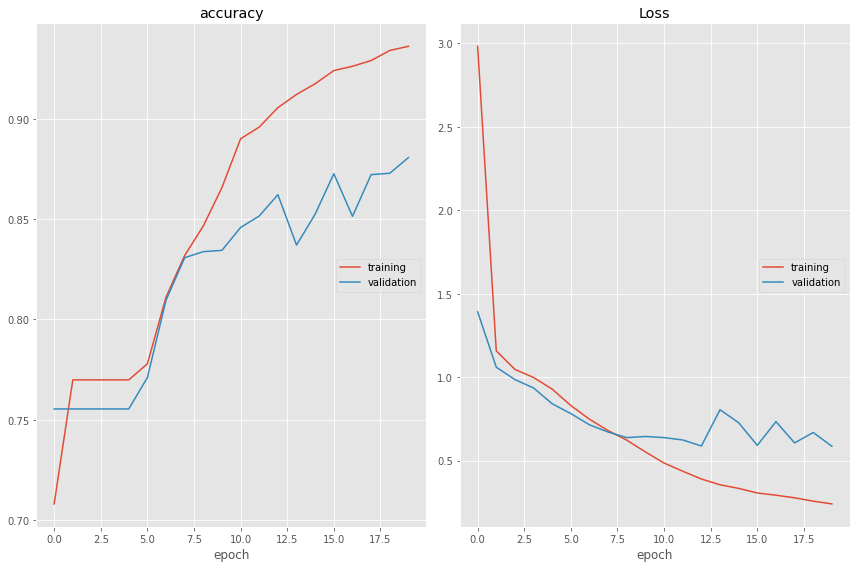

accuracy
	training         	 (min:    0.708, max:    0.936, cur:    0.936)
	validation       	 (min:    0.755, max:    0.881, cur:    0.881)
Loss
	training         	 (min:    0.241, max:    2.983, cur:    0.241)
	validation       	 (min:    0.586, max:    1.392, cur:    0.586)

Epoch 20: val_loss improved from 0.58769 to 0.58612, saving model to model.h5
19/19 [==============================] - 31s 2s/step - loss: 0.2405 - accuracy: 0.9361 - val_loss: 0.5861 - val_accuracy: 0.8807


In [26]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  with tf.device('/device:GPU:0'):
    history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=20,
    callbacks=callbacks,
    verbose=1
)
else:
  history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

## Avalia o modelo com a acurácia e a loss

In [27]:
model.evaluate(x_val,y_val)

3/3 [==============================] - 0s 119ms/step - loss: 0.6695 - accuracy: 0.8613


[0.6694818735122681, 0.8612602949142456]

## Testa o modelo com os dados de validação

In [28]:
y_pred_lstm = model.predict(x_val, batch_size=32, verbose=2)

3/3 - 1s - 1s/epoch - 364ms/step


In [29]:
index_array = np.argmax(y_pred_lstm, axis=-1)

In [30]:
!pip install seqeval

## Calcula o f1-score

In [31]:
from seqeval.metrics import f1_score, classification_report

In [32]:
idx2tag = {v: k for k, v in tag2idx.items()}

In [33]:
def numpy_to_seqeval(y_true, y_pred):

  tags_preditas = []
  ground_truth = []
  for ato in y_pred:
    tags_ato = []
    for palavra in ato:
      tags_ato.append(idx2tag[palavra])
    tags_preditas.append(tags_ato)

  for ato in y_true:
    tags_ato = []
    for palavra in ato:
      tags_ato.append(idx2tag[palavra])
    ground_truth.append(tags_ato)
  
  return ground_truth, tags_preditas

In [34]:
gt, tags_pred = numpy_to_seqeval(y_val, index_array)

In [35]:
f1_score(gt, tags_pred)

0.09289099526066352

## Predição das entidades

In [36]:
from nltk import word_tokenize

In [37]:
def passito_passito(texto, max_len):
    # se keep_punctuation == True
    texto_tokenizado = word_tokenize(texto)
    # caso contrário
    # tokenizador = Regexptokenizer('\w+')
    # texto_tokenizado = tokenizador.tokenize(texto)
    trechos = []
    if len(texto_tokenizado) > max_len:
        num_listas = len(texto_tokenizado) // max_len
        idx_tokens_restantes = num_listas*max_len
        inicio = 0
        for num in range(num_listas):
            fim = (num+1)*max_len
            lista = texto_tokenizado[inicio:fim]
            inicio = (num+1)*max_len
            trechos.append(lista)
            if num == num_listas-1:
                lista = texto_tokenizado[idx_tokens_restantes:]
                trechos.append(lista)
    else:
        trechos.append(texto_tokenizado)
    return trechos

In [38]:
def get_preds(texto, modelo, max_len, word2idx, idx2tag):
    trechos = passito_passito(texto, 250)
    preds_final = []
    texto_tok_final = []

    for trecho in trechos:
        print(f'Qtd de tokens no texto dado: {len(trecho)}')
        index_textos = []
        for word in trecho:
            if word in word2idx.keys():
                index_textos.append(word2idx[word])
            else:
                index_textos.append(word2idx['UNK'])
        index_textos = pad_sequences(maxlen=max_len, sequences=[index_textos], padding='post', value=len(word2idx)-1)
        index_textos = np.array(index_textos)
        pred = modelo.predict(index_textos)
        pred = np.argmax(pred, axis=-1)
        for token, rotulo in zip(trecho, pred[0]):
            texto_tok_final.append(token)
            preds_final.append(idx2tag[rotulo])

    return texto_tok_final, preds_final

In [39]:
import pickle as pkl

with open('word2idx.pkl', 'wb') as f:
  pkl.dump(word2idx, f)

with open('tag2idx.pkl', 'wb') as f:
  pkl.dump(tag2idx, f)

In [40]:
exemplo = 'NOMEAR THAIS OLIVEIRA, Farmacêutico Bioquímico-Farmácia, matrícula 17043700, para exercer o Cargo Público em Comissão, Símbolo CPC-08, SIGRH 55004987, de Gerente, da Gerência de Armazenamento e Distribuição de Medicamentos e Materiais Laboratoriais, da Diretoria de Logística, da Subsecretaria de Logística em Saúde, da Secretaria de Estado de Saúde do Distrito Federal.'
exemplo_tok, preds = get_preds(exemplo, model, 250, word2idx, idx2tag)
for token, tag in zip(exemplo_tok, preds):
    print(f'{token}\t {tag}')

Qtd de tokens no texto dado: 61
NOMEAR	 I-objeto_contrato
THAIS	 I-objeto_contrato
OLIVEIRA	 I-objeto_contrato
,	 I-objeto_contrato
Farmacêutico	 I-objeto_contrato
Bioquímico-Farmácia	 I-objeto_contrato
,	 I-objeto_contrato
matrícula	 I-objeto_contrato
17043700	 I-objeto_contrato
,	 O
para	 I-objeto_contrato
exercer	 I-objeto_contrato
o	 O
Cargo	 O
Público	 O
em	 O
Comissão	 O
,	 O
Símbolo	 O
CPC-08	 O
,	 O
SIGRH	 O
55004987	 O
,	 O
de	 O
Gerente	 O
,	 O
da	 O
Gerência	 O
de	 O
Armazenamento	 O
e	 O
Distribuição	 O
de	 O
Medicamentos	 O
e	 O
Materiais	 O
Laboratoriais	 O
,	 O
da	 O
Diretoria	 O
de	 O
Logística	 O
,	 O
da	 O
Subsecretaria	 O
de	 O
Logística	 O
em	 O
Saúde	 O
,	 O
da	 O
Secretaria	 O
de	 O
Estado	 O
de	 O
Saúde	 O
do	 O
Distrito	 O
Federal	 O
.	 O
